In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet 
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications import xception
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import TextVectorization


seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Internship/Kaggle'

In [ ]:
!kaggle datasets download -d hsankesara/flickr-image-dataset

100% 8.15G/8.16G [01:08<00:00, 202MB/s]
100% 8.16G/8.16G [01:08<00:00, 128MB/s]


In [ ]:
# !wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
# !wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
# !unzip -qq Flickr8k_Dataset.zip
# !unzip -qq Flickr8k_text.zip
# !rm Flickr8k_Dataset.zip Flickr8k_text.zip
!unzip -qq flickr-image-dataset.zip
!rm flickr-image-dataset.zip

In [ ]:

# Path to the images
# IMAGES_PATH = "Flicker8k_Dataset"
IMAGES_PATH = "/content/flickr30k_images/flickr30k_images"

# Desired image dimensions
IMAGE_SIZE = (224, 224)

# Vocabulary size
# VOCAB_SIZE = 10000
VOCAB_SIZE = 30527
# Fixed length allowed for any sequence
# SEQ_LENGTH = 25
SEQ_LENGTH = 50

# Dimension for the image embeddings and token embeddings
# EMBED_DIM = 512
EMBED_DIM = 768

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/flickr30k_images/results.csv', delimiter='|') #
print(df.shape)
print(df.columns[2], df.columns[2] == ' comment') # The column name has the front space
df[' comment'].values[0]
df.head(6)

(158915, 3)
 comment True


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
5,10002456.jpg,0,Several men in hard hats are operating a gian...


In [ ]:
# START_TOKEN = '<start> '
# END_TOKEN = ' <end>'
# def add_start_end(text):
#     return START_TOKEN + str(text) + END_TOKEN

# df['comment'] = df[' comment'].apply(add_start_end)
# df.comment.values[:6]

array(['<start>  Two young guys with shaggy hair look at their hands while hanging out in the yard . <end>',
       '<start>  Two young , White males are outside near many bushes . <end>',
       '<start>  Two men in green shirts are standing in a yard . <end>',
       '<start>  A man in a blue shirt standing in a garden . <end>',
       '<start>  Two friends enjoy time spent together . <end>',
       '<start>  Several men in hard hats are operating a giant pulley system . <end>'],
      dtype=object)

In [ ]:
df[' comment'][:6]

0     Two young guys with shaggy hair look at their...
1     Two young , White males are outside near many...
2     Two men in green shirts are standing in a yard .
3         A man in a blue shirt standing in a garden .
4              Two friends enjoy time spent together .
5     Several men in hard hats are operating a gian...
Name:  comment, dtype: object

In [ ]:
# for i,j in zip(df['image_name'],df[' comment']):
#     print(i,j)

In [ ]:
for i,j in zip(list(df[' comment']),list(df['image_name'])):
    if not isinstance(i, str) :
        print('rip',j)

rip 2199200615.jpg


In [ ]:

def load_captions_data():
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """
    # caption_data = df['comment']
    caption_mapping = {}
    text_data = []
    images_to_skip = set()

    for img_name,caption in zip(list(df['image_name']),list(df[' comment'])):
        # line = line.rstrip("\n")
        # # Image name and captions are separated using a tab
        # img_name, caption = line.split("\t")
        # # Each image is repeated five times for the five different captions.
        # # Each image name has a suffix `#(caption_number)`
        # img_name = img_name.split("#")[0]
        img_name = os.path.join(IMAGES_PATH, img_name.strip())

        # We will remove caption that are either too short to too long
        # print(caption)
        if not isinstance(caption, str):
            print('rip',img_name)
            images_to_skip.add(img_name)
            continue

        tokens = caption.strip().split()

        if len(tokens) < 5 or len(tokens) > 47:
            images_to_skip.add(img_name)
            continue

        if img_name.endswith("jpg") and img_name not in images_to_skip:
            # We will add a start and an end token to each caption
            # caption = "<s> " + caption.strip() + " </s>"
            caption = caption.strip()
            text_data.append(caption)

            if img_name in caption_mapping:
                caption_mapping[img_name].append(caption)
            else:
                caption_mapping[img_name] = [caption]

    for img_name in images_to_skip:
        if img_name in caption_mapping:
            del caption_mapping[img_name]

    return caption_mapping, text_data

In [ ]:
# load_captions_data()

In [ ]:
pip install transformers

     |████████████████████████████████| 3.8 MB 6.1 MB/s 
     |████████████████████████████████| 6.5 MB 35.3 MB/s 
     |████████████████████████████████| 596 kB 41.7 MB/s 
     |████████████████████████████████| 895 kB 42.2 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import AutoTokenizer, AutoModel
from transformers import PreTrainedTokenizer

import torch


#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask



#Sentences we want sentence embeddings for
# sentences = ['This framework generates embeddings for each input sentence',
#              'Sentences are passed as a list of string.',
#              'The quick brown fox jumps over the lazy dog.']

#Load AutoModel from huggingface model repository
# token_model = PreTrainedTokenizer(model_max_length = VOCAB_SIZE, padding_side = 'right', truncation_side = 'right', 
#                                   bos_token = '<start>', eos_token = '<end>', pad_token ='<pad>')


tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-mpnet-base-v2",output_hidden_states=True)

token_ids = tokenizer.encode("This is a sample text to test the tokenizer.",padding='max_length', truncation=True, max_length=SEQ_LENGTH)
print( token_ids )
# print( tokenizer.convert_ids_to_tokens( token_ids ) )
print(tokenizer.decode(token_ids))
#Tokenize sentences
def create_embeddings(sentences):
    encoded_input = tokenizer(sentences, padding='max_length', truncation=True, max_length=SEQ_LENGTH, return_tensors='pt',)

    #Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
    return model_output
    #Perform pooling. In this case, mean pooling
    # sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    # return sentence_embeddings

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

[0, 2027, 2007, 1041, 7103, 3797, 2004, 3235, 2000, 19208, 17633, 1016, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
<s> this is a sample text to test the tokenizer. </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [ ]:

# def load_captions_data(filename):
#     """Loads captions (text) data and maps them to corresponding images.

#     Args:
#         filename: Path to the text file containing caption data.

#     Returns:
#         caption_mapping: Dictionary mapping image names and the corresponding captions
#         text_data: List containing all the available captions
#     """

#     with open(filename) as caption_file:
#         caption_data = caption_file.readlines()
#         caption_mapping = {}
#         text_data = []
#         images_to_skip = set()

#         for line in caption_data:
#             line = line.rstrip("\n")
#             # Image name and captions are separated using a tab
#             img_name, caption = line.split("\t")

#             # Each image is repeated five times for the five different captions.
#             # Each image name has a suffix `#(caption_number)`
#             img_name = img_name.split("#")[0]
#             img_name = os.path.join(IMAGES_PATH, img_name.strip())

#             # We will remove caption that are either too short to too long
#             tokens = caption.strip().split()

#             if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
#                 images_to_skip.add(img_name)
#                 continue

#             if img_name.endswith("jpg") and img_name not in images_to_skip:
#                 # We will add a start and an end token to each caption
#                 caption = "<start> " + caption.strip() + " <end>"
#                 text_data.append(caption)

#                 if img_name in caption_mapping:
#                     caption_mapping[img_name].append(caption)
#                 else:
#                     caption_mapping[img_name] = [caption]

#         for img_name in images_to_skip:
#             if img_name in caption_mapping:
#                 del caption_mapping[img_name]

#         return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: [tf.constant(tokenizer.encode(sent,padding='max_length', truncation=True, max_length=SEQ_LENGTH), dtype=tf.int64) for sent in caption_data[img_name]] for img_name in all_images[:train_size]
    }
    train_caps = [['<s> ' + caps + ' </s' for caps in caption_data[img_name]] for img_name in all_images[:train_size]]
    validation_data = {
        img_name: [tf.constant(tokenizer.encode(sent,padding='max_length', truncation=True, max_length=SEQ_LENGTH), dtype=tf.int64) for sent in caption_data[img_name]] for img_name in all_images[train_size:]
    }
    valid_caps = [['<s> ' + caps + ' </s' for caps in caption_data[img_name]] for img_name in all_images[train_size:]]
    # 4. Return the splits
    return training_data, validation_data, train_caps, valid_caps


# Load the dataset
# captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")
captions_mapping, text_data = load_captions_data()
# Split the dataset into training and validation sets
train_data, valid_data, train_cap, valid_cap = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

rip /content/flickr30k_images/flickr30k_images/2199200615.jpg
Number of training samples:  25048
Number of validation samples:  6262


In [ ]:
for i in captions_mapping.values():
    print([tf.constant(tokenizer.encode(sent,padding='max_length', truncation=True, max_length=SEQ_LENGTH), dtype=tf.int32) for sent in i])
    break

[<tf.Tensor: shape=(50,), dtype=int32, numpy=
array([    0,  2052,  2406,  4368,  2011, 25745,  2610,  2302,  2016,
        2041,  2402,  2100,  5693,  2045,  2003,  2000,  4224,  1016,
           2,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1], dtype=int32)>, <tf.Tensor: shape=(50,), dtype=int32, numpy=
array([    0,  2052,  2406,  1014,  2321,  3771,  2028,  2652,  2383,
        2120, 14572,  1016,     2,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1], dtype=int32)>, <tf.Tensor: shape=(50,), dtype=int32, numpy=
array([    0,  2052,  2277,  2003,  2669, 11348,

In [ ]:
text_data[:5]
len(text_data)

157925

In [ ]:

# def custom_standardization(input_string):
#     lowercase = tf.strings.lower(input_string)
#     return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


# strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
# strip_chars = strip_chars.replace("<", "")
# strip_chars = strip_chars.replace(">", "")

# vectorization = TextVectorization(
#     max_tokens=VOCAB_SIZE,
#     output_mode="int",
#     output_sequence_length=SEQ_LENGTH,
#     standardize=custom_standardization,
# )
# vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
        # layers.RandomZoom((-0.2,0.2))
    ]
)


In [ ]:
# def token_func(sentences):
#     t1 = tf.zeros([0, SEQ_LENGTH],tf.int32)
#     # t1 = tokenizer.encode(sentences[0],padding='max_length', truncation=True, max_length=SEQ_LENGTH,return_tensors = 'tf')
#     for sentence in sentences:
#         t2 = tokenizer.encode(sentence,padding='max_length', truncation=True, max_length=SEQ_LENGTH,return_tensors = 'tf')
#         t1 = tf.concat([t1, t2], 0)
#     return tf.cast(t1,tf.int64)

In [ ]:
# token_func(["Hello little hat mad","Blue yellow green","no idea"])

In [ ]:
# vectorization = TextVectorization(
#     max_tokens=VOCAB_SIZE,
#     output_mode="int",
#     output_sequence_length=SEQ_LENGTH,
#     standardize=None,
#     vocabulary = [tokenizer.convert_ids_to_tokens(i) for i in range(VOCAB_SIZE-2)]
# )

In [ ]:
# vectorization.get_config()

{'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 30527,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 70,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': None,
 'trainable': True,
 'vocabulary': ListWrapper(['<s>', '<pad>', '</s>', '<unk>', '[PAD]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[unused31]', '[unused32]', '[unused33]', '[unused34]', '[unused35]', '[unused36]', '[unused37]', '[unused38]', '[unused39]', '[unused40]', '[unused41]', '[unused42]', '[unused43]', '[unused44]', '[unused45]',

In [ ]:
# from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
# token_ids = [i for i in range(30527)]
# token_words = tokenizer.convert_ids_to_tokens( token_ids )
# for i,sent in enumerate(sent_list):
#     for j,word in enumerate(sent):
#         word_pos[word].append([i,j])
# for i in token_words:
#     if i not in word_pos:
#         word_pos[i] = None
# word_pos = {word:[[sent_no,pos_no],...]}

In [ ]:
# for i,j in word_pos.items():
#    

In [ ]:
# first_arr = create_embeddings(text_data[:100])

In [ ]:
text_data[0]

' Two young guys with shaggy hair look at their hands while hanging out in the yard .'

In [ ]:
# def get_word_idx(sent: str, word: str):
#     return sent.split(" ").index(word)
 
 
def get_hidden_states(encoded, token_ids_word, output):
    """Push input IDs through model. Stack and sum `layers` (last four by default).
      Select only those subword token outputs that belong to our word of interest
      and average them."""
    
    # Only select the tokens that constitute the requested word
    word_tokens_output = output[token_ids_word]

    return word_tokens_output.mean(dim=0)
 
 
def get_word_vector(sent, idx, tokenizer, model, layers):
    """Get a word vector by first tokenizing the input sentence, getting all token idxs
      that make up the word of interest, and then `get_hidden_states`."""
    encoded = tokenizer(sent, padding=True, truncation=True, max_length=SEQ_LENGTH, return_tensors='pt')
    with torch.no_grad():
        output = model(**encoded)
    # Get all hidden states
    states = output.hidden_states
    # Stack and sum all requested layers
    output = torch.stack([states[i] for i in layers]).sum(0).squeeze()
    sentence_emb = []
    # get all token idxs that belong to the word of interest
    for i in idx:
        token_ids_word = np.where(np.array(encoded.word_ids()) == i)
        sentence_emb.append(get_hidden_states(encoded, token_ids_word, output).numpy())

    return sentence_emb
 
def get_sent_embedding(sent,word = None,layers=None):
    # Use last four layers by default
    layers = [-4, -3, -2, -1] if layers is None else layers
    #  tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
    #  model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)

    #  sent = "I like cookies ." 
    # idx = get_word_idx(sent, word)
    sent = sent.strip()
    idx = [i for i in range(len(sent.split()))]

    sent_embedding = get_word_vector(sent, idx, tokenizer, model, layers)

    return sent_embedding 
 

In [ ]:
x = tokenizer.encode("tokenizer")
for i in x[1:-1]:
    print(i)

19208
17633


In [ ]:
embedding_matrix = np.zeros((VOCAB_SIZE,EMBED_DIM))

In [ ]:
pad = np.zeros((2,EMBED_DIM))
embedding_matrix = np.concatenate((pad,embedding_matrix))

In [ ]:
embedding_matrix.shape

(30527, 768)

In [ ]:
def update_embedding(data_list):
    tot = 0
    for sent in data_list:
        sent_embedding = get_sent_embedding(sent)
        cnt = 0
        for word in sent.split():
            rel = tokenizer.encode(word)
            for r in rel[1:-1]:
                # print(embedding_matrix[r])
                embedding_matrix[r] += sent_embedding[cnt]
                # print(embedding_matrix[r])
            cnt += 1
        if tot%1000 == 0:
            print(tot)
        tot += 1

In [ ]:
for i in range(VOCAB_SIZE):
    word = tokenizer.convert_ids_to_token(i)
    if word in word_count:
        embedding_matrix[i] = embedding_matrix[i] / word_count[word]

In [ ]:
# data_list = ["Yellow green orange","top hat cycle cookies"]
update_embedding(text_data)

0
1000
2000
3000


KeyboardInterrupt: ignored

In [ ]:
#@title Default title text
# def get_word_idx(sent: str, word: str):
#     return sent.split(" ").index(word)
 
 
# def get_hidden_states(encoded, token_ids_word, model, layers):
#     """Push input IDs through model. Stack and sum `layers` (last four by default).
#       Select only those subword token outputs that belong to our word of interest
#       and average them."""
#     with torch.no_grad():
#         output = model(**encoded)

#     # Get all hidden states
#     states = output.hidden_states
#     # Stack and sum all requested layers
#     output = torch.stack([states[i] for i in layers]).sum(0).squeeze()
#     # Only select the tokens that constitute the requested word
#     word_tokens_output = output[token_ids_word]

#     return word_tokens_output.mean(dim=0)
 
 
# def get_word_vector(sent, idx, tokenizer, model, layers):
#     """Get a word vector by first tokenizing the input sentence, getting all token idxs
#       that make up the word of interest, and then `get_hidden_states`."""
#     encoded = tokenizer(sent, padding=True, truncation=True, max_length=SEQ_LENGTH, return_tensors='pt')
#     # get all token idxs that belong to the word of interest
#     token_ids_word = np.where(np.array(encoded.word_ids()) == idx)

#     return get_hidden_states(encoded, token_ids_word, model, layers)
 
 
# def get_word_embedding(sent,word,layers=None):
#     # Use last four layers by default
#     layers = [-4, -3, -2, -1] if layers is None else layers
#     #  tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
#     #  model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)

#     #  sent = "I like cookies ." 
#     idx = get_word_idx(sent, word)

#     word_embedding = get_word_vector(sent, idx, tokenizer, model, layers)

#     return word_embedding 
 

In [ ]:
VOCAB_SIZE = model.config.vocab_size

In [ ]:
print( tokenizer.convert_ids_to_tokens( 20106 ) )

relocate


In [ ]:
model.config

MPNetConfig {
  "_name_or_path": "sentence-transformers/all-mpnet-base-v2",
  "architectures": [
    "MPNetForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "mpnet",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.17.0",
  "vocab_size": 30527
}

In [ ]:

def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path,captions=None):
    # print(type(captions))
    if captios is None:
        return decode_and_resize(img_path)
    return decode_and_resize(img_path),captions#, vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(len(images))
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))


In [ ]:
# train_dataset = (
#         tf.data.Dataset
#         .from_tensor_slices((list(train_data.keys()), list(train_data.values())))
#         .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
#         .shuffle(len(list(train_data.keys())))
#         .batch(BATCH_SIZE)
#         .prefetch(AUTOTUNE)
#     )

In [ ]:
def get_cnn_model():
    base_model = DenseNet121(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False

    # base_model_out = base_model.layers[-4].output
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

In [ ]:
test_model = get_cnn_model()

In [ ]:
test_model.summary()

In [ ]:
# self.embedding = tf.keras.layers.Embedding(self.vocab_size, embedding_matrix.shape[1], 
#                                                embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), 
#                                                trainable=False,
#                                                mask_zero=True)

In [ ]:

# def get_cnn_model():
#     base_model = efficientnet.EfficientNetB0(
#         input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
#     )
#     # We freeze our feature extractor
#     base_model.trainable = False
#     base_model_out = base_model.output
#     base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
#     cnn_model = keras.models.Model(base_model.input, base_model_out)
#     return cnn_model




class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        ) 
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

class EncoderLayer(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.2
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        # self.layernorm_3 = layers.LayerNormalization()
        # self.dropout_1 = layers.Dropout(rate=0.2)
        self.dense_1 = layers.Dense(embed_dim, activation="relu")
        # self.dense_2 = layers.Dense(embed_dim, activation="relu")
        # self.ffn_2 = layers.Dense(embed_dim)

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)

        # out_1 = self.dense_2(out_1)
        # out_1 = self.ffn_2(out_1)
        # out_1 = self.dropout_1(out_1, training=training)
        # out_2 = self.layernorm_3(out_1 + attention_output_1)

        return out_1


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, n_layers, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.n_layers = n_layers
        # self.embedding = PositionalEmbedding(
        #     embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        # )
        # self.dropout = layers.Dropout(rate=0.1)
        self.enc_layers = [EncoderLayer(embed_dim, dense_dim, num_heads) for _ in range(n_layers)]

    def call(self, inputs, training, mask=None):

        # outputs = self.embedding(inputs)
        # outputs = self.dropout(outputs,training)
        for i in range(self.n_layers):
            inputs = self.enc_layers[i](inputs, training, mask)
        return inputs

class DecoderLayers(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.2
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.2
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, combined_mask, padding_mask):

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        return ffn_out


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, n_layers, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayers(embed_dim, ff_dim, num_heads) for _ in range(n_layers)]

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        # self.embedding = tf.keras.layers.Embedding(self.vocab_size, embedding_matrix.shape[1], 
        #                                        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), 
        #                                        trainable=False,
        #                                        mask_zero=True)
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout = layers.Dropout(0.2)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)
        
        outputs = self.dropout(inputs, training = training)
        # outputs1 = self.dec_layers[0](outputs, encoder_outputs, training, combined_mask, padding_mask)
        # outputs2 = self.dec_layers[1](outputs1, encoder_outputs, training, combined_mask, padding_mask)
        # outputs3 = self.dec_layers[2](outputs2, encoder_outputs, training, combined_mask, padding_mask)
        # outputs4 = self.dec_layers[3](outputs1, encoder_outputs, training, combined_mask, padding_mask)
        # foutputs = tf.keras.layers.Concatenate()([outputs3, outputs4])
        for i in range(self.n_layers):
            outputs = self.dec_layers[i](outputs, encoder_outputs, training, combined_mask, padding_mask)

        preds = self.out(outputs)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        # loss_ = tf.nn.compute_average_loss(loss_, global_batch_size=BATCH_SIZE)
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        # tf.print(tf.argmax(y_pred, axis=2))
        # accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        # tf.print(tf.shape(accuracy))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 1)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )# change
        # tf.print(tf.shape(batch_seq_true))
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0  
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )# change

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}# change

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )# change

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}# change

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(n_layers = 2,embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(n_layers = 2,embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

In [ ]:

# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor="val_acc",patience=5, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)# change

In [ ]:
# Fit the model
r = caption_model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=valid_dataset,
        callbacks=[early_stopping],
    )

Epoch 1/30


In [ ]:
caption_model.save_weights('/content/drive/MyDrive/Internship/ImageCapDense121Wt')

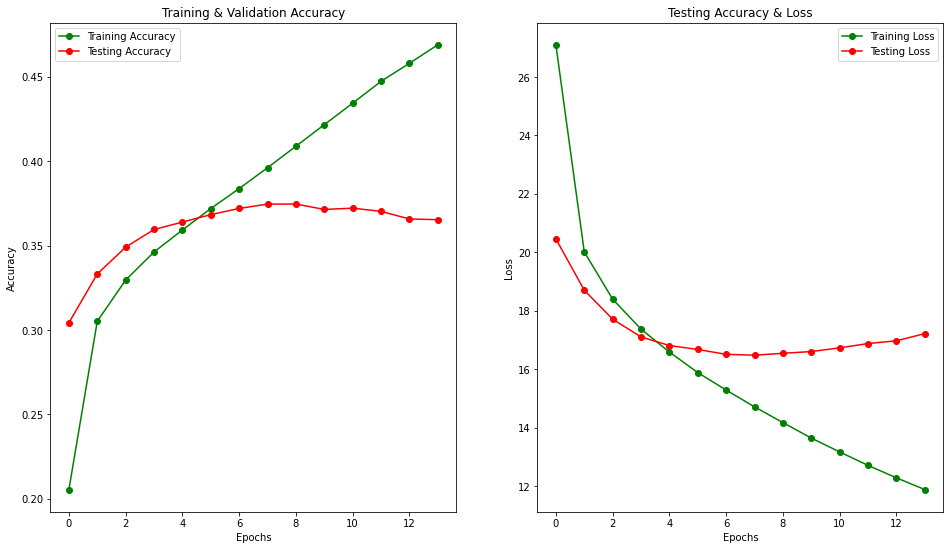

In [ ]:
import matplotlib.pyplot as plt
epochs = [i for i in range(14)]
fig , ax = plt.subplots(1,2)
train_acc = r.history['acc']
train_loss = r.history['loss']
val_acc = r.history['val_acc']
val_loss = r.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

# Tried to save


In [ ]:
# caption_model.build((None, 224, 224, 3))

In [ ]:
# caption_model.summary()

In [ ]:
# input_shape=(224, 224, 3)
# model=caption_model(input_shape)

In [ ]:
# caption_model.compute_output_shape(input_shape=(None, 224, 224, 3))

In [ ]:
# new_model = ImageCaptioningModel(
#     cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
# )

In [ ]:
caption_model.save_weights('ImageCapDenseNet121_E1D1Wt')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# new_model.load_weights('ImageCapEfficientNetB0Wt')

In [ ]:
# new_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)# change
# new_model.fit(
#         train_dataset,
#         epochs=EPOCHS,
#         validation_data=valid_dataset,
#         callbacks=[early_stopping],
#     )

In [ ]:
# new_model.summary()

In [ ]:
# caption_model.save('ImageCapEfficientNetB0.pb')

# Score

In [ ]:
 pip install "git+https://github.com/salaniz/pycocoevalcap.git"

  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-3qzofd_2
  Running command git clone -q https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-3qzofd_2
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312215 sha256=77b9c734756d341ee4f656d73315e34962dd5468bc1d34d4ea3739d4aae036d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-_u4z6deq/wheels/6f/c9/51/e266f0496048c16686e133d8e33644d692931a356bfb372aae
Successfully built pycocoevalcap


In [ ]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor

def scorefunc(ref, hypo):
    scorers = [
        (Bleu(4),["Bleu_1","Bleu_2","Bleu_3","Bleu_4"]),
        (Meteor(),"METEOR"),
        (Rouge(),"ROUGE_L"),
        (Cider(),"CIDEr")
    ]
    final_scores = {}
    for scorer,method in scorers:
        score,scores = scorer.compute_score(ref,hypo)
        if type(score)==list:
            for m,s in zip(method,score):
                final_scores[m] = s
        else:
            final_scores[method] = score

    return final_scores

In [ ]:
tokenizer.convert_ids_to_tokens(2)

'</s>'

In [ ]:
vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=None,
)
vectorization.adapt(text_data)

In [ ]:
vectorization(["Hello"])[:, :-1]

<tf.Tensor: shape=(1, 49), dtype=int64, numpy=
array([[4497,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0]])>

In [ ]:
tf.constant(tokenizer.encode('',padding='max_length', truncation=True, max_length=SEQ_LENGTH), dtype=tf.int32)[]

<tf.Tensor: shape=(50,), dtype=int32, numpy=
array([0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)>

In [ ]:
tokenizer.encode('this is an tokenizer',padding='max_length', truncation=True, max_length=SEQ_LENGTH)

[0,
 2027,
 2007,
 2023,
 19208,
 17633,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [ ]:
# vocab = vectorization.get_vocabulary()
# index_lookup = dict(zip(range(len(vocab)), vocab))# use
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption(x,y,ref1,hypo1):
    n = 0
    # Select a random image from the validation dataset
    for valid_image in valid_images[x:y]:
        sample_img = valid_image
        sample_captions = valid_data[sample_img]
        
        # Read the image from the disk
        sample_img = decode_and_resize(sample_img)
        img = sample_img.numpy().clip(0, 255).astype(np.uint8)
        # plt.imshow(img)
        # plt.show()

        # Pass the image to the CNN
        img = tf.expand_dims(sample_img, 0)
        img = caption_model.cnn_model(img)

        # Pass the image features to the Transformer encoder
        encoded_img = caption_model.encoder(img, training=False)

        # Generate the caption using the Transformer decoder
        # decoded_caption = "<start> "
        decoded_caption = ""
        for i in range(max_decoded_sentence_length):
            # tokenized_caption = vectorization([decoded_caption])[:, :-1]
            tokenized_caption = tf.constant([tokenizer.encode(decoded_caption,padding='max_length', truncation=True, max_length=SEQ_LENGTH)], dtype=tf.int32)[:, :-1]
            mask = tf.math.not_equal(tokenized_caption, 0)
            predictions = caption_model.decoder(
                tokenized_caption, encoded_img, training=False, mask=mask
            )
            # predictions[0, i, :]
            sampled_token_index = np.argmax(predictions[0, i, :])# use
            sampled_token = tokenizer.convert_ids_to_tokens(int(sampled_token_index))
            # sampled_token = index_lookup[sampled_token_index]
            if sampled_token == " </s>":
                break
            decoded_caption += " " + sampled_token

        decoded_caption = decoded_caption.replace("<s> ", "")
        decoded_caption = decoded_caption.replace(" </s>", "").strip()
        # print("Predicted Caption: ", decoded_caption)
        ref1[valid_image] = sample_captions
        hypo1[valid_image] = [decoded_caption]
        
        if(n%10 == 0):
            print(n)
        n+=1

# Check predictions for a few samples
# generate_caption()

In [ ]:
tref = {}
thypo = {}
generate_caption(0,1,tref,thypo)

0


In [ ]:
print(tref,thypo)

{'/content/flickr30k_images/flickr30k_images/6175830478.jpg': [<tf.Tensor: shape=(50,), dtype=int32, numpy=
array([    0,  1041,  2454,  2007,  2656,  2009,  2000,  3919,  7458,
        2140,  1014, 11871, 17475,  3074,  2000,  3612,  2062,  2000,
        5662,  1016,     2,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1], dtype=int32)>, <tf.Tensor: shape=(50,), dtype=int32, numpy=
array([    0,  1041,  2271,  7458,  2451, 19551,  2000,  3612,  1014,
        5786,  2004,  3560,  1041,  2395,  1016,     2,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1], dtype=int32)>, <tf.Tensor: shape=(50,), dtype=

In [ ]:
# import threading

# threads = []
# x = 0
# y = 128

# n_threads = 10

# listrefs = [{} for _ in range(10)]
# listhypos = [{} for _ in range(10)]

# for i in range(n_threads):
#     threads.append(threading.Thread(target=generate_caption, args=(x,y,listrefs[i],listhypos[i])))
#     x += 128
#     y += 128

# for i in range(n_threads):
#     threads[i].start()

In [ ]:
import threading

threads = []
x = 0
y = 128

n_threads = 12

listrefs = [{} for _ in range(n_threads)]
listhypos = [{} for _ in range(n_threads)]

for i in range(n_threads):
    threads.append(threading.Thread(target=generate_caption, args=(x,y,listrefs[i],listhypos[i])))
    x += 128
    y += 128

for i in range(n_threads):
    threads[i].start()

In [ ]:
for i in range(n_threads):
    threads[i].join()

0
0
0
0
0
0
0
0
0
0
0
0
10
10
10
10
10
10
10
10
10
10
10
10
20
20
20
20
20
20
20
20
20
2020

20
30
30
30
30
30
30
30
30
30
30
30
30
40
40
40
40
40
40
40
40
40
40
40
40
50
50
50
50
50
50
50
50
50
50
50
50
60
60
60
60
60
60
60
60
60
60
60
60
70
70
70
70
70
70
70
70
70
70
70
70
80
80
80
80
80
80
80
80
80
80
80
80
90
90
90
90
90
90
90
90
90
90
90
90
100
100
100
100
100
100
100
100
100
100
100
100
110
110
110
110
110
110
110
110
110
110
110
110
120
120
120
120
120
120
120
120
120
120
120
120


In [ ]:
# generate_caption(1280,1529,ref1,hypo1):

In [ ]:
ref = {}
hypo = {}

for i in range(n_threads):
    ref.update(listrefs[i])
    hypo.update(listhypos[i])

In [ ]:
len(ref)

1529

In [ ]:
len(hypo)

1529

In [ ]:
improveRef = {}
for i,j in ref.items():
    for k in j:
        k = k.replace("<start> ", "")
        k = k.replace(" <end>", "")
        k = k.replace(" .", "")
        if i in improveRef:
            improveRef[i].append(k)
        else:
            improveRef[i] = [k]

In [ ]:
scorefunc(improveRef, hypo)

{'testlen': 14865, 'reflen': 14841, 'guess': [14865, 13336, 11807, 10278], 'correct': [7243, 2280, 662, 215]}
ratio: 1.0016171417019741


{'Bleu_1': 0.4872519340732938,
 'Bleu_2': 0.2886233186049223,
 'Bleu_3': 0.16715796910291592,
 'Bleu_4': 0.09942091966779927,
 'CIDEr': 0.24856483630728826,
 'METEOR': 0.1509999922623416,
 'ROUGE_L': 0.32065346123782024}

## Bleu score using corpus_bleu

In [ ]:
# import pickle
# with open('ref.pickle', 'wb') as handle:
#     pickle.dump(ref, handle)

In [ ]:
# with open('hypo.pickle', 'wb') as handle:
#     pickle.dump(hypo, handle)

In [ ]:
# with open('ref.pickle', 'rb') as handle:
#     check_ref = pickle.load(handle)

In [ ]:
# with open('hypo.pickle', 'rb') as handle:
#     check_hypo = pickle.load(handle)

In [ ]:
# check_ref

In [ ]:
# check_hypo

In [ ]:
ref

In [ ]:
improveRef

{'Flicker8k_Dataset/632608471_a70461f123.jpg': ['A group of little girls perform a recital onstage dressed in all white',
  'Eleven girls in white tutus stand and pose onstage',
  'Group of ballerinas in white tutus get ready to dance',
  'The little ballerinas are all wearing white bows , dresses and leggings',
  'Young girl ballerinas in white tutus on a stage'],
 'Flicker8k_Dataset/3366904106_e996320d20.jpg': ['A boy in an orange shirt grinds a skateboard ramp',
  'a lone skateboarder wearing an orange shirt jumping on a ramp',
  'A skateboarder uses a ramp',
  'A young man in an orange shirt , maneuvers a skateboard at the top of a ramp',
  'Skateboarder on a ramp as seen through a chain link fence'],
 'Flicker8k_Dataset/3547524138_4157f660b0.jpg': ['Adults and children are playing with water balloons in the street',
  'A group of people play a game in the road',
  'A group of people play a game in the street , passing balloons to one another',
  'People passing water balloons in t

In [ ]:
hypo

{'Flicker8k_Dataset/632608471_a70461f123.jpg': ['a group of children are standing on a trampoline'],
 'Flicker8k_Dataset/3366904106_e996320d20.jpg': ['a young boy in a white shirt is standing on a fence'],
 'Flicker8k_Dataset/3547524138_4157f660b0.jpg': ['a girl in a pink dress is dancing'],
 'Flicker8k_Dataset/2264316030_600e55748d.jpg': ['a brown dog is running through the snow'],
 'Flicker8k_Dataset/424379231_23f1ade134.jpg': ['a dog jumps over a fence'],
 'Flicker8k_Dataset/78984436_ad96eaa802.jpg': ['a black and white dog is running on the grass'],
 'Flicker8k_Dataset/2369248869_0266760c4a.jpg': ['a black dog is running through the water'],
 'Flicker8k_Dataset/766346887_a9a9d0637a.jpg': ['a little boy is laying on a trampoline'],
 'Flicker8k_Dataset/2920305300_a5b1b2329a.jpg': ['a man wearing a red shirt is riding a bike'],
 'Flicker8k_Dataset/3272071680_648a99f7d2.jpg': ['a woman in a black shirt and a woman in a black shirt'],
 'Flicker8k_Dataset/3329858093_0ec73f2190.jpg': ['tw

In [ ]:
newRef = []
newHypo = []
for r in improveRef.values():
    newRef.append([i.split() for i in r])

for h in hypo.values():
    newHypo.append(h[0].split())

In [ ]:
# [i.split() for i in h]

In [ ]:
len(newRef)

1280

In [ ]:
len(newHypo)

1280

In [ ]:
newHypo

[['a', 'group', 'of', 'children', 'are', 'standing', 'on', 'a', 'trampoline'],
 ['a',
  'young',
  'boy',
  'in',
  'a',
  'white',
  'shirt',
  'is',
  'standing',
  'on',
  'a',
  'fence'],
 ['a', 'girl', 'in', 'a', 'pink', 'dress', 'is', 'dancing'],
 ['a', 'brown', 'dog', 'is', 'running', 'through', 'the', 'snow'],
 ['a', 'dog', 'jumps', 'over', 'a', 'fence'],
 ['a', 'black', 'and', 'white', 'dog', 'is', 'running', 'on', 'the', 'grass'],
 ['a', 'black', 'dog', 'is', 'running', 'through', 'the', 'water'],
 ['a', 'little', 'boy', 'is', 'laying', 'on', 'a', 'trampoline'],
 ['a', 'man', 'wearing', 'a', 'red', 'shirt', 'is', 'riding', 'a', 'bike'],
 ['a',
  'woman',
  'in',
  'a',
  'black',
  'shirt',
  'and',
  'a',
  'woman',
  'in',
  'a',
  'black',
  'shirt'],
 ['two',
  'children',
  'are',
  'standing',
  'in',
  'a',
  'parking',
  'lot',
  'of',
  'war'],
 ['two',
  'people',
  'are',
  'standing',
  'on',
  'a',
  'city',
  'street',
  'with',
  'a',
  'red',
  'car',
  'in',


In [ ]:
newRef

[[['<start>',
   'A',
   'group',
   'of',
   'little',
   'girls',
   'perform',
   'a',
   'recital',
   'onstage',
   'dressed',
   'in',
   'all',
   'white',
   '.',
   '<end>'],
  ['<start>',
   'Eleven',
   'girls',
   'in',
   'white',
   'tutus',
   'stand',
   'and',
   'pose',
   'onstage',
   '.',
   '<end>'],
  ['<start>',
   'Group',
   'of',
   'ballerinas',
   'in',
   'white',
   'tutus',
   'get',
   'ready',
   'to',
   'dance',
   '<end>'],
  ['<start>',
   'The',
   'little',
   'ballerinas',
   'are',
   'all',
   'wearing',
   'white',
   'bows',
   ',',
   'dresses',
   'and',
   'leggings',
   '.',
   '<end>'],
  ['<start>',
   'Young',
   'girl',
   'ballerinas',
   'in',
   'white',
   'tutus',
   'on',
   'a',
   'stage',
   '.',
   '<end>']],
 [['<start>',
   'A',
   'boy',
   'in',
   'an',
   'orange',
   'shirt',
   'grinds',
   'a',
   'skateboard',
   'ramp',
   '.',
   '<end>'],
  ['<start>',
   'a',
   'lone',
   'skateboarder',
   'wearing',
   'an'

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
print('BLEU-1: %f' % corpus_bleu(newRef, newHypo, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(newRef, newHypo, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(newRef, newHypo, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(newRef, newHypo, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.559032
BLEU-2: 0.372241
BLEU-3: 0.276802
BLEU-4: 0.150377


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
print('BLEU-1: %f' % corpus_bleu(ref, hypo, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(ref, hypo, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(ref, hypo, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(ref, hypo, weights=(0.25, 0.25, 0.25, 0.25)))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.624984
BLEU-2: 0.790559
BLEU-3: 0.868482
BLEU-4: 0.889134


In [ ]:
 # sample_caption_new = []
#         for i in sample_captions:
#             i = i.replace("<start>","")
#             i = i.replace(" <end>","").strip()
#             sample_caption_new.append(i)

#         print(sample_caption_new)
#         score = scorefunc(sample_caption_new, decoded_caption)
        
#         print("Score: ",score)
#         n+=1
#         if(n == 5): break